<a href="https://colab.research.google.com/github/edmarRod/Courses/blob/main/Statistics/3_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B testing definitions
A/B testing is a method for detecting whether a change produces an effect via statistic methods.

## Key terms in A/B testing:

**Overall Evaluation Criterion (OEC):** A quantitative measure of the experiment's objective. e.g. Increased active days per user or increased model performance.

**Parameter/variable**: A controllable experiment variable that is thought to change the OEC or other metrics of interest. e.g. Font color or a model hyperparameter.

**Variant:** The different experiences being tested by assigning values to different parameters. Here the variants are A and B, also called the Control and Treatment. The Control is where there is no change to the status quo, while Treatment would be the alternative being tested. e.g. Control would be the current webpage, while Treatment would be the same webpage with a different font color. For modelling, Control would be the current model or a baseline model, while Treatment would be a new proposed model.

**Randomization Unit:** The unit to which randomization is applied to map a variant, e.g. a user to a webpage variant, or a set of input features to a model variant.

## Example 1: Is our new model better?

OEC: Accuracy

Parameter: Model used

Variants:
  - A: DecisionTree
  - B: RandomForest

Randomization Unit: Sample/Test Set (although both models are used for the same samples)

In [ ]:
signficance_level = 0.05
power = 0.8
effect_size = 0.2

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
np.random.seed(55)

def bootstrap_acc(y_true: np.array, y_pred: np.array, n_iterations: int = 10) -> list[float]:
  """Use bootstrap to get accuracy samples.
  """
  accuracy_scores = []
  for i in range(n_iterations):
    bootstrap_sample = np.random.choice(len(y_true), size=len(y_true), replace=True)
    bootstrap_y_true = y_true[bootstrap_sample]
    bootstrap_y_pred = y_pred[bootstrap_sample]
    accuracy_scores.append(accuracy_score(bootstrap_y_true, bootstrap_y_pred))

  return accuracy_scores

# load the iris dataset
iris_data = load_iris()
X = iris_data.data
y = iris_data.target

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# fit the model
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
accs_dt = bootstrap_acc(y_test, yhat)
acc_dt = accuracy_score(y_test, yhat)

# fit the model
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
accs_rf = bootstrap_acc(y_test, yhat)
acc_rf = accuracy_score(y_test, yhat)


In [ ]:
print(f"Accuracies\n A :{acc_dt}\n B: {acc_rf}")

Accuracies
 A :0.9666666666666667
 B: 0.9666666666666667


In [ ]:
print(f"Accuracy bootstrap samples\n A :{accs_dt}\n B: {accs_rf}")

Accuracy bootstrap samples
 A :[1.0, 1.0, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9333333333333333, 1.0, 0.9666666666666667, 0.9666666666666667, 1.0]
 B: [0.9333333333333333, 0.9666666666666667, 1.0, 1.0, 1.0, 0.9666666666666667, 1.0, 0.9666666666666667, 0.9, 0.9666666666666667]


In [ ]:
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower

ttest = ttest_ind(a=accs_dt, b=accs_rf, equal_var=False)
analysis = TTestIndPower()
result = analysis.solve_power(effect_size, nobs1=len(accs_dt), ratio=1.0, alpha=signficance_level)
print(f" TTest Results: {ttest}")
print(f" TTest Power: {result}")

 TTest Results: TtestResult(statistic=0.526234811584221, pvalue=0.6060153727438121, df=15.840449906269525)
 TTest Power: 0.07082134517132738


# Example 2: Production Line Speed Increase

In this example we have a ficticious production line which works for 6-8 hours then takes a maintenance break for 2-4 hours, the also works every day. This production line has various equipments which work in sequence at different speeds. Currently the speed of the line is set manually and adjusted by the operators. The goal is to introduce a new model which controls the speed of the line so that the total output of the line is maximized.

Additionally, we know we only have a maximum of 2 weeks for testing and based on previously collected data we know that the average output for a working period at manual speed is 1000, with standard deviation of 100.

After talks with leadership and cost analysis for the implementation of the solution, we know that any increase below 100 units would not be feasible for implementation.

How can we organize this test, and what would be our metrics?

OEC: Production Line Output

Parameter: Usage of model vs No Model for speed control

Variants:
  - A: Manually decide the speed
  - B: Speed being controlled by a Model

Randomization Unit: Production Line Work Unit (In this case we can force alternation between A/B instead of randomizing, so we can have a 50/50 split)

For the effect size we can use Cohen's d:
\begin{align}
  d = \frac{\bar{x}_1 - \bar{x}_2}{s}
\end{align}
where $s$ will be the known standard deviation, $\bar{x}_1$ will be the minimum output to be able to implement the solution and $\bar{x}_2$ will be the average manual output.

In [ ]:
import numpy as np
from scipy.stats import ttest_ind
from scipy import stats
from statsmodels.stats.power import TTestIndPower
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)

manual_output = 1000
manual_std = 100
true_model_output = 1100
min_model_output_for_effect = 1100
num_weeks = 2

significance_level = 0.05
cohens_d = (min_model_output_for_effect - manual_output) / manual_std


sample_size = (num_weeks*7*24/(7+3))/2# Number of hours worked for each week divided by (7 avg hours per work + 3 avg hours for maintenance), then divided by 2 since there will be a 50/50 split

analysis = TTestIndPower()
result = analysis.solve_power(effect_size=cohens_d, nobs1=sample_size, ratio=1.0, alpha=significance_level)
print(f"TTest Power: {result}")

TTest Power: 0.8021262230954551


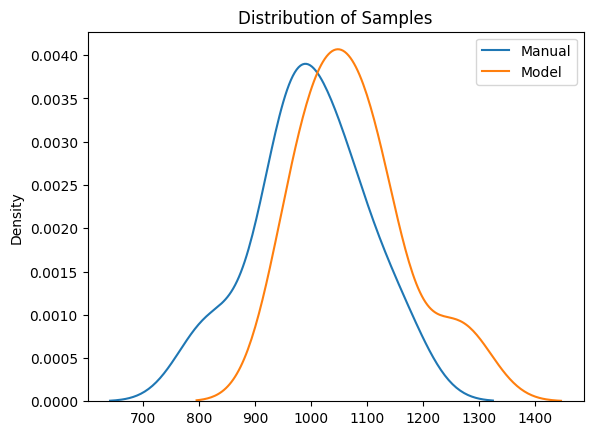

TTest Results: TtestResult(statistic=-2.299882510415261, pvalue=0.02858888884163611, df=30.0)
 Average effect: 1075.0826522561833 
 Confidence Intervals: (10.356233491672498, 144.89731682370584)


In [ ]:
manual_samples = np.random.normal(loc=manual_output, scale=manual_std, size=int(sample_size))
model_samples = np.random.normal(loc=true_model_output, scale=manual_std, size=int(sample_size))

sns.kdeplot(manual_samples, label="Manual")
sns.kdeplot(model_samples, label="Model")
plt.legend()
plt.title("Distribution of Samples")
plt.show()

ttest = ttest_ind(a=manual_samples, b=model_samples, equal_var=True)
analysis = TTestIndPower()
result = analysis.solve_power(cohens_d, nobs1=sample_size, ratio=1.0, alpha=significance_level)
print(f"TTest Results: {ttest}")

df = ttest.df

ll = (model_samples.mean() - manual_samples.mean()) + stats.t.ppf(significance_level/2, df)*np.sqrt((model_samples.std(ddof=1)**2/sample_size) + (manual_samples.std(ddof=1)**2/sample_size))
ul = (model_samples.mean() - manual_samples.mean()) - stats.t.ppf(significance_level/2, df)*np.sqrt((model_samples.std(ddof=1)**2/sample_size) + (manual_samples.std(ddof=1)**2/sample_size))

print(f" Average effect: {model_samples.mean()} \n Confidence Intervals: ({ll}, {ul})")